### Notebook for running SONATA on t_branch dataset
Below, we replicate our results for t_branch dataset reported in *SONATA: Disambiguated manifold alignment of single-cell data.*




In [1]:
import os.path as osp
import yaml
from easydict import EasyDict

import sys
sys.path.insert(1, '../src/')
import sonata
from utils.utils import *
from utils.vis import *
import scotv1

In [2]:
# load parameters and datasets
cfg_url='../src/cfgs/t_branch.yaml'
with open(cfg_url, 'r',encoding='utf8') as file:
        cfg = EasyDict(yaml.safe_load(file))
basename = osp.basename(osp.dirname(cfg.data_path.dataset_url1))
print("dataset name={}".format(basename))

data1 = load_data(cfg.data_path.dataset_url1)
data2 = load_data(cfg.data_path.dataset_url2)
label1 = load_data(cfg.data_path.label_url1)
label2 = load_data(cfg.data_path.label_url2)
print("data1 shape={}\tdata2 shape={}".format(data1.shape, data2.shape))
print("label1 shape={}\tlabel2 shape={}".format(label1.shape, label2.shape))


dataset name=t_branch
data1 shape=(300, 1000)	data2 shape=(300, 2000)
label1 shape=(300,)	label2 shape=(300,)


### 1. visualize two modalities

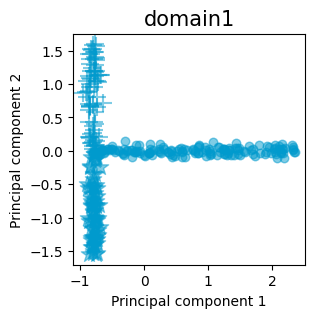

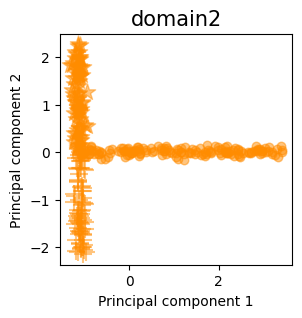

In [3]:
plt_domain_by_label(data1, label1, color='#009ACD', title='domain1', show=True)
plt_domain_by_label(data2, label2, color='#FF8C00', title='domain2', show=True)

### 2. Mapping by SCOT (or any other manifold aligners)

In [4]:
scot = scotv1.SCOT(data1.copy(), data2.copy())
scot.align(k = cfg.scot.k, e=cfg.scot.e, mode=cfg.scot.mode, metric=cfg.scot.metric, normalize=cfg.scot.normalize)
mapping = scot.coupling
x_aligned, y_aligned = projection_barycentric(scot.X, scot.y, mapping, XontoY = cfg.plt.XontoY)

It.  |Err         
-------------------
    0|7.674563e-03|


/Users/zhouhan/Applications/anaconda3/envs/py38/lib/python3.8/site-packages/ot/bregman.py:536: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


   10|5.386003e-12|


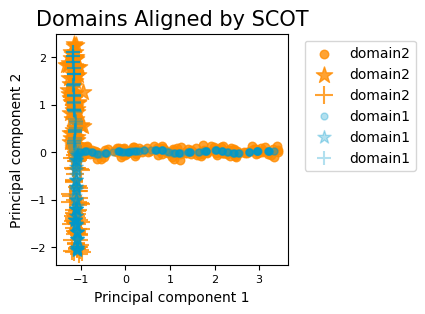

In [5]:
plt_mapping_by_label(x_aligned, y_aligned, label1, label2, show=True)

### 3. cell-cell alternaltive mappings from SONATA

In [6]:
sn = sonata.sonata(kmin=cfg.sonata.kmin, sigma=cfg.sonata.sigma, t=cfg.sonata.t)
alter_mappings = sn.alt_mapping(data=data1) 

constructing knn graph ...
final k =10
calculating cell-wise ambiguity ...
calculating group-wise ambiguity ...
deciding best k for clustering ...
K = 2 groups choosen by elbow method


#### 3.1 cell-cell ambiguities

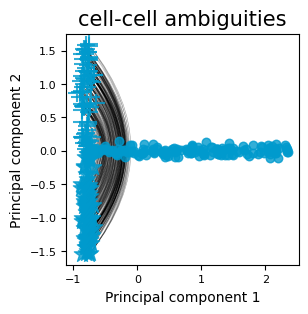

In [7]:
plt_cannotlink_by_label(data1, sn.ambiguous_nodes, label1, sn.ambiguous_links, show=True, link_style=True)

#### 3.2 Ambiguous groups

class_label=0	class_indices=[ 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117]
class_label=1	class_indices=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60]


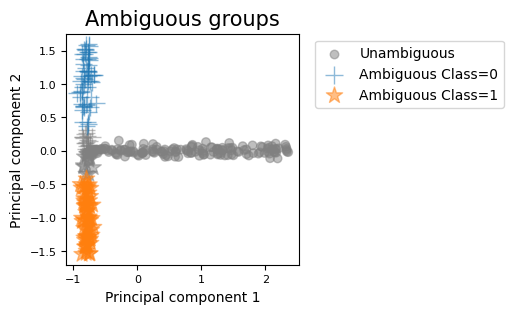

In [8]:
plt_ambiguous_groups_by_label(data1, sn.ambiguous_nodes, sn.cluster_labels, label1, show=True)

#### 3.3 k elbow to determine group numbers

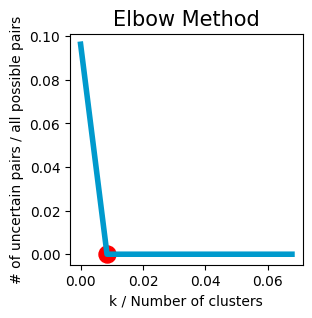

In [9]:
plt_k_elbow(x_step=sn.K_xstep, yerror=sn.K_yerror, best_k=sn.K, show=True)

#### 3.4 Alternative alignments

all vaild perms are:  [(1, 0)]
perms:  (1, 0)
changed group id:  0 1
changed group id:  1 0


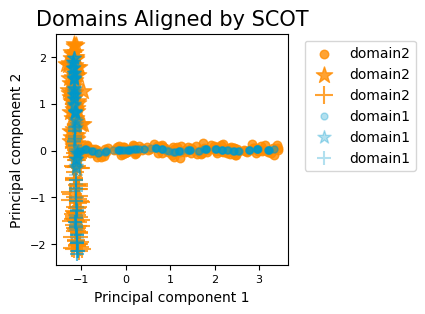

In [10]:

for idx, m in enumerate(alter_mappings, start=1):
    this_mapping = np.matmul(m, mapping)
    x_aligned, y_aligned = projection_barycentric(scot.X, scot.y, this_mapping, XontoY = cfg.plt.XontoY)
    plt_mapping_by_label(x_aligned, y_aligned, label1, label2, show=True)